<a href="https://colab.research.google.com/github/MrCoeg/Skripsi/blob/main/Full%20predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipython-autotime

%load_ext autotime

from torch.utils.data import DataLoader
from tqdm import tqdm

import torch
import cv2
import sys
import gdown

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np

sys.path.append("../")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00
time: 6.62 s (started: 2023-08-24 07:28:36 +00:00)


In [ ]:
file_id = "1f1YDfcYRZo2XzkJAsIg1YZHUHd0THABB"
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
)
!unzip 'Dataset.zip'

file_id = "1WoGJ8Q_f2QFs5l05B1sZCFucndAPbgKc"
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
)
!unzip 'Rest.zip' -d 'Dataset/rgb'

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1f1YDfcYRZo2XzkJAsIg1YZHUHd0THABB
To: /content/Dataset.zip
100%|██████████| 390M/390M [00:02<00:00, 165MB/s]


Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Dataset/rgb/00037591.jpg  
  inflating: Dataset/rgb/00037538.jpg  
  inflating: Dataset/rgb/00037543.jpg  
  inflating: Dataset/rgb/00037547.jpg  
  inflating: Dataset/rgb/00037553.jpg  
  inflating: Dataset/rgb/00037563.jpg  
  inflating: Dataset/rgb/00037549.jpg  
  inflating: Dataset/rgb/00037545.jpg  
  inflating: Dataset/rgb/00037558.jpg  
  inflating: Dataset/rgb/00037562.jpg  
  inflating: Dataset/rgb/00037511.jpg  
  inflating: Dataset/rgb/00037519.jpg  
  inflating: Dataset/rgb/00037542.jpg  
  inflating: Dataset/rgb/00037554.jpg  
  inflating: Dataset/rgb/00037552.jpg  
  inflating: Dataset/rgb/00037615.jpg  
  inflating: Dataset/rgb/00037548.jpg  
  inflating: Dataset/rgb/00037561.jpg  
  inflating: Dataset/rgb/00037555.jpg  
  inflating: Dataset/rgb/00037539.jpg  
  inflating: Dataset/rgb/00037512.jpg  
  inflating: Dataset/rgb/00037520.jpg  
  inflating: Dataset/rgb/00037541.jpg  
  inflating: Dataset/

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1WoGJ8Q_f2QFs5l05B1sZCFucndAPbgKc
To: /content/Rest.zip
100%|██████████| 428M/428M [00:02<00:00, 158MB/s]


Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Dataset/rgb/00060120.jpg  
  inflating: Dataset/rgb/00060121.jpg  
  inflating: Dataset/rgb/00060122.jpg  
  inflating: Dataset/rgb/00060123.jpg  
  inflating: Dataset/rgb/00060124.jpg  
  inflating: Dataset/rgb/00060125.jpg  
  inflating: Dataset/rgb/00060126.jpg  
  inflating: Dataset/rgb/00060127.jpg  
  inflating: Dataset/rgb/00060128.jpg  
  inflating: Dataset/rgb/00060129.jpg  
  inflating: Dataset/rgb/00060130.jpg  
  inflating: Dataset/rgb/00060131.jpg  
  inflating: Dataset/rgb/00060132.jpg  
  inflating: Dataset/rgb/00060133.jpg  
  inflating: Dataset/rgb/00060134.jpg  
  inflating: Dataset/rgb/00060135.jpg  
  inflating: Dataset/rgb/00060136.jpg  
  inflating: Dataset/rgb/00060137.jpg  
  inflating: Dataset/rgb/00060138.jpg  
  inflating: Dataset/rgb/00060139.jpg  
  inflating: Dataset/rgb/00060140.jpg  
  inflating: Dataset/rgb/00060141.jpg  
  inflating: Dataset/rgb/00060142.jpg  
  inflating: Dataset/

In [ ]:
N_IMG_CHANNELS = 3

MODEL_IMG_SIZE = 128
RAW_IMG_SIZE = 224

DATASET_MEANS = [0.4837, 0.4650, 0.4397]
DATASET_STDS = [0.2331, 0.2338, 0.2659]

time: 1.22 ms (started: 2023-08-24 07:29:26 +00:00)


In [186]:
NAMES_KEYPOINTS = [
    "Wrist",
    "Thumb_CMC", "Thumb_MCP", "Thumb_DIP", "Thumb_TIP",
    "Index_MCP", "Index_PIP", "Index_DIP", "Index_TIP",
    "Middle_MCP", "Middle_PIP", "Middle_DIP", "Middle_TIP",
    "Ring_MCP", "Ring_PIP", "Ring_DIP", "Ring_TIP",
    "Pinky_MCP", "Pinky_PIP", "Pinky_DIP", "Pinky_TIP",
]

# COLORMAP = {
#     "thumb": {"ids": [0], "color": "g"},
#     "index": {"ids": [1], "color": "c"},
#     "middle": {"ids": [2], "color": "b"},
#     "ring": {"ids": [3], "color": "m"},
#     "little": {"ids": [4], "color": "r"},
# }

COLORMAP = {
    "tip": {"ids": [], "color": "g"},
    "dip": {"ids": [], "color": "c"},
    "pip": {"ids": [], "color": "b"},
    "mcp": {"ids": [0,1,2,3,4,5], "color": "m"},
}
# Blur Size
FG = 57
FGK = [4]

INDEX_KEYPOINTS = [0,1,5,9,13,17]
# INDEX_KEYPOINTS = [0,2,5,9,13,17]
# INDEX_KEYPOINTS = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
N_KEYPOINTS = len(INDEX_KEYPOINTS)
KEYS_KEYPOINTS = [NAMES_KEYPOINTS[i] for i in INDEX_KEYPOINTS]

time: 895 µs (started: 2023-08-24 15:51:41 +00:00)


In [ ]:
# Model Tunning Config
train_config = {
    "data_dir": "Dataset",
    "model_neuron": 8,
    "epochs": 1000,
    "batch_size": 8,
    "batches_per_epoch": 249,
    "batches_per_epoch_val": 16,
    "learning_rate": 0.1,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

# Test Config
test_config = {
    "data_dir": "Dataset/",
    "model_neuron": 8,
    "model_path": "model_final",
    "batch_size": 1,
    "device": torch.device("cuda"),
}

time: 47.6 ms (started: 2023-08-24 07:29:36 +00:00)


In [ ]:
# Mengubah 3D keypoint dari Freihand Dataset menjadi 2D Keypoint
# Operasi memanfaatkan Camera Intrinsik
# Kode disediakan dari Dataset
def projectPoints(xyz, K):
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    uv = uv[:, :2] / uv[:, -1:]
    return uv[INDEX_KEYPOINTS]

# Kode ini untuk mencari mean dan std dari dataset
def get_norm_params(dataloader):
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    # perulangan untuk iterate dataloader pytorch dengan return index dan batch data
    for i, sample in tqdm(enumerate(dataloader)):

        # mengambil raw image dari iterasi batch pertama
        data = sample["image_raw"]

        # berapa banyak image dalam satu batch
        batch_samples = data.size(0)

        # re-shape data menjadi [batch, channel, num_pixel]
        data = data.view(batch_samples, data.size(1), -1)

        # mendapatkan mean dan std menggunakan fungsi mean dan sum
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return {"mean": mean, "std": std}

# kode ini untuk mengubah keypoint menjadi heatmap
def vector_to_heatmaps(keypoints):
    # membuat heatmap kosong
    heatmaps = np.zeros([N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE])

    # iterate keypoint yang ada
    for k, (x, y) in enumerate(keypoints):

        # mengubah keypoint koordinate menjadi heatmap
        # kordinate x,y akan dijadikan 1 pada heatmap untuk proses blur
        x, y = int(x * MODEL_IMG_SIZE), int(y * MODEL_IMG_SIZE)
        if (0 <= x < MODEL_IMG_SIZE) and (0 <= y < MODEL_IMG_SIZE):
            heatmaps[k, int(y), int(x)] = 1

    # blur heatmap agar model menjadi robust
    heatmaps = blur_heatmaps(heatmaps)

    return heatmaps

# blur image menggunakan gaussianblur
def blur_heatmaps(heatmaps):
    heatmaps_blurred = heatmaps.copy()
    # nilai heatmap satu yang merupakan koordinat keypoint
    # dilakukan pengebluran menggunakan gaussian blur
    for k in range(len(heatmaps)):
        if heatmaps_blurred[k].max() == 1:
            heatmaps_blurred[k] = cv2.GaussianBlur(heatmaps[k], (FG, FG), FGK[0])
            heatmaps_blurred[k] = heatmaps_blurred[k] / heatmaps_blurred[k].max()
    return heatmaps_blurred


def CountModelParameter(model):
  parameter_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return parameter_count


# Loss function IoU

class IoULoss(nn.Module):
    def __init__(self, config):
        super(IoULoss, self).__init__()
        self.EPSILON = 1e-6
        self.max_euclidean_distance = torch.norm(
            torch.tensor([MODEL_IMG_SIZE, MODEL_IMG_SIZE]).float() -
            torch.tensor([0, 0]).float()
        )
        self.device = config["device"]



    def _op_sum(self, x):
        return x.sum(dim=-1).sum(dim=-1)

    def heatmaps_to_coordinates(self, x):
        # mendapatkan banyak image dalam batch
        batch_size = x.size(0)

        # mendapatkan nilai total dari heatmap width dan height
        sums = x.sum(dim=-1).sum(dim=-1)
        sums = sums.unsqueeze(2).unsqueeze(3)

        # normalisasi heatmap dengan membagi nilai heatmap dengan nilai total heatmap
        # sehingga hasil berada pada range 0 dan 1
        normalized = (x + self.EPSILON) / (sums+self.EPSILON)

        # mendapatkan nilai total pada normalized heatmap dari width dan height nya
        x_prob = normalized.sum(dim=2)
        y_prob = normalized.sum(dim=3)

        # membuat heatmap baru sebagai kordinat dengan size 0 hingga MODEL_IMG_SIZE - 1
        arr = torch.arange(0, MODEL_IMG_SIZE).float().unsqueeze(0).unsqueeze(1).to(self.device)
        arr = arr.expand(batch_size, N_KEYPOINTS, -1)

        # mendapatkan kordinat dengan mengkalikan normalized vector heatmap dengan heatmap kordinat baru
        # ini bertujuan untuk meningkatkan keakuratan dari keypoint output menggunakan value yang telah di normalisasi
        x = torch.sum(arr * x_prob, dim=2)
        y = torch.sum(arr * y_prob, dim=2)

        # register kordinat pada tensor
        keypoints = torch.stack([x, y], dim=-1)

        # normaliasasi kembali
        return keypoints / (MODEL_IMG_SIZE - 1)

    # Rumus untuk mendapatkan IoU
    def forward(self, y_pred, y_true):
        inter = self._op_sum(y_true * y_pred)
        union = self._op_sum((y_true ** 2) + (y_pred ** 2) - (y_true * y_pred))
        iou = (inter + self.EPSILON) / (union + self.EPSILON)
        iou = torch.mean(iou)
        return 1 - iou



# mengubah heatmap kembali menjadi kordinat
def heatmaps_to_coordinates(heatmaps):

    # mendapatkan banyak image dalam batch
    batch_size = heatmaps.shape[0]

    # mendapatkan nilai total dari heatmap width dan height
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])

    # normalisasi heatmap dengan membagi nilai heatmap dengan nilai total heatmap
    # sehingga hasil berada pada range 0 dan 1
    normalized = heatmaps / sums

    # mendapatkan nilai total pada normalized heatmap dari width dan height nya
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)

    # membuat heatmap baru sebagai kordinat dengan size 0 hingga 127 -> dimensi
    arr = np.tile(np.float32(np.arange(0, MODEL_IMG_SIZE)), [batch_size, N_KEYPOINTS, 1])

    # mendapatkan kordinat dengan mengkalikan normalized vector heatmap dengan heatmap kordinat baru
    # ini bertujuan untuk meningkatkan keakuratan dari keypoint output menggunakan value yang telah di normalisasi
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)

    # register kordinat pada array
    keypoints = np.stack([x, y], axis=-1)

    # normaliasasi kembali
    return keypoints / MODEL_IMG_SIZE

# Visualisasi sample data
def show_data(dataset, n_samples=4 ):
    plt.figure(figsize=[12, 4 * n_samples])
    ids = np.random.choice(dataset.__len__(), n_samples-1, replace=False)
    print(ids)

    # iterate random sample image
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        # mendapatkan image raw
        image_raw = sample["image_raw"].numpy()
        image_raw = np.moveaxis(image_raw, 0, -1)

        #visualisasi image raw
        plt.subplot(n_samples, 4, i * 4 + 1)
        plt.imshow(image_raw)

        # mendapatkan keypoint image raw
        keypoints = sample["keypoints"].numpy()
        keypoints = keypoints * RAW_IMG_SIZE

        # visualiasai keypoint image raw menggunakan scatter dan plot
        # plot memanfaatkan colormap yang telah dibuat untuk visualisasi
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
        plt.title("Raw Image Keypoint")
        plt.axis("off")

        # mendapatkan image input
        plt.subplot(n_samples, 4, i * 4 + 2)
        image = sample["image"].numpy()
        cv2.resize(image, (RAW_IMG_SIZE,RAW_IMG_SIZE))
        image = np.moveaxis(image, 0, -1)


        # mendapatkan heatmap image input
        heatmaps = sample["heatmaps"].numpy()
        plt.imshow(heatmaps[0])
        # mengubah heatmap image input menjadi keypoint
        input_keypoints = heatmaps_to_coordinates(heatmaps.reshape(1, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))
        input_keypoints = input_keypoints[0] * MODEL_IMG_SIZE;

        # visualiasai keypoint image input menggunakan scatter dan plot
        # plot memanfaatkan colormap yang telah dibuat untuk visualisasi
        # plt.scatter(input_keypoints[:, 0], input_keypoints[:, 1], c="k", alpha=0.5)
        # for finger, params in COLORMAP.items():
        #    plt.plot(
        #        input_keypoints[params["ids"], 0],
        #        input_keypoints[params["ids"], 1],
        #        params["color"],
        #    )
        plt.title("Input Image")
        plt.axis("off")

        # visualisasi histogram dari image raw
        image_raw = image_raw * 255
        plt.subplot(n_samples, 4, i * 4 + 3)
        plt.hist(image_raw.ravel(),256,[0,256])
        plt.title("Raw Hist")
        plt.axis("off")

        # visualisasi histogram dari image input
        image = image * 255
        plt.subplot(n_samples, 4, i * 4 + 4)
        plt.hist(image.ravel(),256,[0,256])
        plt.title("Input Hist")
        plt.axis("off")


    plt.tight_layout()
    plt.show()


# Visualisasi prediksi model
def show_batch_predictions(batch_data, model):

    # mendapatkan image input
    inputs = batch_data["image"]
    inputs = inputs.cuda()

    # mendapatkan actual heatmap
    true_keypoints = batch_data["heatmaps"].numpy()
    batch_size = true_keypoints.shape[0]

    # mendapatkan actual keypoint
    true_keypoints = heatmaps_to_coordinates(true_keypoints.reshape(batch_size, N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE))

    # melakukan prediksi
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()

    # mendapatkan prediksi heatmap
    pred_heatmaps = pred_heatmaps.detach().numpy()

    # mendapatkan prediksi keypoint
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    # mendapatkan setiap input image
    inputs = inputs.cpu()
    images = inputs.numpy()
    images = np.moveaxis(images, 1, -1)

    plt.figure(figsize=[12, 4 * batch_size])

    # iterate setiap input image
    for i in range(batch_size):

        # mendapatkan image pada setiap iterasi
        image = images[i]

        # resize image menjadi 224 * 224
        image = cv2.resize(image, (RAW_IMG_SIZE, RAW_IMG_SIZE))

        # resize keypoint mengikuti ukuran image
        true_keypoints_img = true_keypoints[i] * RAW_IMG_SIZE
        pred_keypoints_img = pred_keypoints[i] * RAW_IMG_SIZE

        # visualisasi image input
        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        # visualisasi image input untuk actual keypoint
        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(image)
        plt.scatter(true_keypoints_img[:, 0], true_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                true_keypoints_img[params["ids"], 0],
                true_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("True Keypoints")
        plt.axis("off")

        # visualisasi image input untuk prediksi keypoint
        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(image)
        plt.scatter(pred_keypoints_img[:, 0], pred_keypoints_img[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                pred_keypoints_img[params["ids"], 0],
                pred_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("Pred Keypoints")
        plt.axis("off")
    plt.tight_layout()
    plt.tight_layout()
    plt.show()

time: 18 ms (started: 2023-08-24 09:53:01 +00:00)


In [ ]:
import numpy as np
import os
from PIL import Image
import json
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import random

class FreiHAND(Dataset):

    def __init__(self, config, set_type="train"):

        # mendapatkan image path
        self.set_type = set_type
        self.device = config["device"]
        self.image_dir = os.path.join(config["data_dir"], "rgb")
        self.image_names = np.sort(os.listdir(self.image_dir))

        # filtering image
        self.image_names = [img for img in self.image_names if not img.endswith(('.ipynb_checkpoint', '.zip'))]

        # mendapatkan intrinsik kamera
        fn_K_matrix = os.path.join(config["data_dir"], "training_K.json")
        with open(fn_K_matrix, "r") as f:
            self.K_matrix = np.array(json.load(f))

        # mendapatkan 3d keypoint
        fn_anno = os.path.join(config["data_dir"], "training_xyz.json")
        with open(fn_anno, "r") as f:
            self.anno = np.array(json.load(f))

        # fn_tunning_anno = "keypoint_tuning_xyz.json"
        # with open(fn_tunning_anno, "r") as f:
        #     self.tunning_anno = np.array(json.load(f))

        # split dataset menjadi train, val dan test
        if set_type == "train":
            n_start = 0
            n_end = 12000
        elif set_type == "val":
            n_start = 12000
            n_end = 14000
        else:
            n_start = 14000
            n_end = 15000

        self.image_names = self.image_names[n_start:n_end]
        # self.K_matrix = self.K_matrix[n_start:n_end]
        # self.anno = self.anno[n_start:n_end]

        # Image preprocesing dan augmentation

        # raw image preprocesing
        self.image_raw_transform = transforms.ToTensor()

        # input image preprocesing
        self.image_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),

            ]
        )

        # input image preprocesing dengan flip horizontal
        self.image_transform_flipped_horizontal = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
            ]
        )

        # input image preprocesing dengan flip vertical
        self.image_transform_flipped_vertical = transforms.Compose(
            [
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
            ]
        )

        # input image preprocesing dengan flip horizontal dan flip vertical
        self.image_transform_flipped_both = transforms.Compose(
            [

                transforms.RandomHorizontalFlip(1),
                transforms.RandomVerticalFlip(1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
            ]
        )

        self.image_transform_resize = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
            ]
        )

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):

        # mendapatkan image sesuai index pemanggil
        image_name = self.image_names[idx]
        anno_idx = int(image_name[2:8]) % 32560
        # instance image menggunakan PIL
        image_raw = Image.open(os.path.join(self.image_dir, image_name))

        image = self.image_transform_resize(image_raw)

        # mengubah 3D keypoint menjadi 2D Keypoint menggunakan Intrinsik kamera
        keypoints = projectPoints(self.anno[anno_idx], self.K_matrix[anno_idx])

        # Normalisasi keypoint
        keypoints = keypoints / RAW_IMG_SIZE

        # mengubah keypoint menjadi heatmaps
        heatmaps = vector_to_heatmaps(keypoints)

        # mengubah heatmap jadi tensor
        heatmaps = torch.from_numpy(np.float32(heatmaps))

        # melakukan image preprocesing dan augmentation terhadapa input image dan heatmapnya
        flip_probability = random.random()

        if  self.set_type == "test":
          flip_probability = 0.1

        if 0 < flip_probability < 0.25:
          image = self.image_transform(image)
        elif 0.25 < flip_probability < 0.5:
          image = self.image_transform_flipped_horizontal(image)
          heatmaps = transforms.functional.hflip(heatmaps)
        elif 0.5 < flip_probability < 0.75:
          image = self.image_transform_flipped_vertical(image)
          heatmaps = transforms.functional.vflip(heatmaps)
        else:
          image = self.image_transform_flipped_both(image)
          heatmaps = transforms.functional.hflip(heatmaps)
          heatmaps = transforms.functional.vflip(heatmaps)

        # mengubah image_raw dan keypoint jadi tensor
        image_raw = self.image_raw_transform(image_raw)
        keypoints = torch.from_numpy(keypoints)

        return {
            "image": image,
            "keypoints": keypoints,
            "heatmaps": heatmaps,
            "image_name": image_name,
            "image_raw": image_raw,
        }

time: 237 ms (started: 2023-08-24 07:30:59 +00:00)


In [ ]:
import torch
import torch.nn as nn

# Depthwise Separable Convolution Block
class DepthwiseSeparableConvBlock(nn.Module):
  def __init__(self, in_depth, out_depth):
      super().__init__()
      self.double_conv = nn.Sequential(

          nn.BatchNorm2d(in_depth),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=1,stride=1,padding=0,bias=True),

          nn.BatchNorm2d(in_depth),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=1,stride=1,padding=0,bias=True),

          nn.BatchNorm2d(in_depth),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=True),
      )

      self.skip = nn.Sequential(
          nn.Conv2d(in_channels=in_depth,out_channels=in_depth,kernel_size=3,stride=1,padding=1,groups=in_depth,bias=True),
          nn.Conv2d(in_channels=in_depth,out_channels=out_depth,kernel_size=1,stride=1,padding=0,bias=True),
      )



  def forward(self, x):
      double_conv = self.double_conv(x)
      skip = self.skip(x)
      return double_conv + skip


class DepthwiseUNet(nn.Module):
  def __init__(self, in_channel, out_channel, model_neurons):
      super().__init__()
      self.quant = torch.ao.quantization.QuantStub()
      self.dequant = torch.ao.quantization.DeQuantStub()
      # self.post_processing = PostProcessOutput(out_channel, 128)

      self.maxpool = nn.MaxPool2d(2)
      self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

      self.conv_in = nn.Sequential(
          nn.Conv2d(in_channel, model_neurons, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(model_neurons),
          nn.ReLU(inplace=True),
      )

      # ConvBlock Encoder
      self.conv_down1 = DepthwiseSeparableConvBlock(model_neurons, model_neurons * 2)
      self.conv_down2 = DepthwiseSeparableConvBlock(model_neurons * 2, model_neurons * 4)
      self.conv_down3 = DepthwiseSeparableConvBlock(model_neurons * 4, model_neurons * 8)

      # # Middle
      # self.conv_middle1 = DepthwiseSeparableConvBlock(model_neurons, model_neurons*2)
      # self.conv_middle2 = DepthwiseSeparableConvBlock(model_neurons*2, model_neurons*4)
      # self.conv_middle3 = DepthwiseSeparableConvBlock(model_neurons*4, model_neurons*8)


      # ConvBlock Bottleneck
      self.conv_bottleneck = DepthwiseSeparableConvBlock(model_neurons * 8, model_neurons * 8)


      # ConvBlock Decoder
      self.conv_up1 = DepthwiseSeparableConvBlock(
          model_neurons * 8, model_neurons * 4
      )
      self.conv_up2 = DepthwiseSeparableConvBlock(
          model_neurons * 4, model_neurons * 2
      )
      self.conv_up3 = DepthwiseSeparableConvBlock(
          model_neurons * 2 , model_neurons
      )
      # self.conv_up4 = DepthwiseSeparableConvBlock(
      #     MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS
      # )


      # Output layer
      self.conv_out = nn.Sequential(
          nn.Conv2d(model_neurons, out_channel, kernel_size=3, padding=1, bias=False),
          nn.Sigmoid(),
      )



  def forward(self, x):
      # quant = self.quant(x)
      conv_re = self.conv_in(x)
      conv_d1 = self.conv_down1(conv_re)
      conv_d2 = self.conv_down2(self.maxpool(conv_d1))
      conv_d3 = self.conv_down3(self.maxpool(conv_d2))

      conv_b = self.conv_bottleneck(self.maxpool(conv_d3))

      conv_u1 = self.conv_up1(self.upsample(conv_b) + conv_d3)
      conv_u2 = self.conv_up2(self.upsample(conv_u1) + conv_d2)
      conv_u3 = self.conv_up3(self.upsample(conv_u2) + conv_d1)
      out = self.conv_out(conv_u3)
      # dequant = self.dequant(out)
      # post_processed = self.post_processing(dequant)
      return out

time: 1.71 ms (started: 2023-08-24 07:31:04 +00:00)


In [ ]:
import numpy as np
import torch

# membuat class custom untuk training
class Trainer:
    def __init__(self, model, criterion, optimizer, config, scheduler=None):
        self.best_model = model.state_dict()
        self.current_best_lost = 1
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss = {"train": [], "val": []}
        self.epochs = config["epochs"]
        self.batches_per_epoch = config["batches_per_epoch"]
        self.batches_per_epoch_val = config["batches_per_epoch_val"]
        self.device = config["device"]
        self.scheduler = scheduler
        self.checkpoint_frequency = 20
        self.early_stopping_epochs = 10
        self.early_stopping_avg = 10
        self.early_stopping_precision = 5

    def train(self, train_dataloader, val_dataloader, test_dataloader, blur):
        for epoch in range(self.epochs):
            self._epoch_train(train_dataloader)
            self._epoch_eval(val_dataloader)
            print(
                "Epoch: {}/{}, Train Loss={}, Val Loss={}".format(
                    epoch + 1,
                    self.epochs,
                    np.round(self.loss["train"][-1], 10),
                    np.round(self.loss["val"][-1], 10),
                )
            )
            # visualisasi testing
            #for data in test_dataloader:
            #    show_batch_predictions(data, model)
            #    break

            #if((epoch+1)%3 == 0 and epoch < 20):
            #    blur[0]= blur[0]- 0.15

            # menurukan learning rate jika tidak ada perkembangan
            if self.scheduler is not None:
                # self.scheduler.step(self.loss["train"][-1])
                self.scheduler.step()

            if (self.loss["val"][-1] < self.current_best_lost):
              self.best_model = model.state_dict()
              self.current_best_lost = self.loss["val"][-1]


            # saving model setiap 20 epoch
            if (epoch + 1) % self.checkpoint_frequency == 0:
                torch.save(
                    self.model.state_dict(), "model_{}".format(str(epoch + 1).zfill(3))
                )

            # early stopping untuk menghindari overfitting
            if epoch < self.early_stopping_avg:
                min_val_loss = np.round(np.mean(self.loss["val"]), self.early_stopping_precision)
                no_decrease_epochs = 0

            # early stop akan terjadi jika nilai rata - rata dari 10 loss val terakhir tidak kunjung menurun selama
            # early_stopping_epochs berturut turut
            else:
                val_loss = np.round(
                    np.mean(self.loss["val"][-self.early_stopping_avg:]),
                                    self.early_stopping_precision
                )
                if val_loss >= min_val_loss:
                    no_decrease_epochs += 1
                else:
                    min_val_loss = val_loss
                    no_decrease_epochs = 0

            if no_decrease_epochs > self.early_stopping_epochs:
                print("Early Stopping")
                break

        torch.save(self.model.state_dict(), "model_final")
        return self.model

    def _epoch_train(self, dataloader):

        # mengubah mode model menjadi mode training
        self.model.train()
        running_loss = []
        # iterate data training
        for i, data in enumerate(dataloader, 0):
            # mendapatkan input image batch
            inputs = data["image"].to(self.device)
            # mendapatkan input heatmap image batch
            labels = data["heatmaps"].to(self.device)

            # memngubah gradient menjadi zero untuk mencegah terjadinya kesalahan update parameter model
            self.optimizer.zero_grad()

            # melakukan prediksi training
            outputs = self.model(inputs)

            # menghitung loss
            loss = self.criterion(outputs, labels)

            # menghitung gradient untuk update parameter
            loss.backward()

            # update parameter model
            self.optimizer.step()

            # append loss batch ini
            running_loss.append(loss.item())


        # final loss untuk epoch training ini
        epoch_loss = np.mean(running_loss)
        self.loss["train"].append(epoch_loss)

    def _epoch_eval(self, dataloader):

        # mengubah mode model menjadi mode eval
        self.model.eval()
        running_loss = []

        # nonaktifkan gradient komputasi
        with torch.no_grad():

            # iterate data training eval
            for i, data in enumerate(dataloader, 0):
                # mendapatkan input image batch
                inputs = data["image"].to(self.device)
                # mendapatkan input heatmap image batch
                labels = data["heatmaps"].to(self.device)

                # melakukan prediksi eval
                outputs = self.model(inputs)

                # menghitung loss
                loss = self.criterion(outputs, labels)

                overall_loss = loss

                # append loss batch ini
                running_loss.append(loss.item())

                # final loss untuk epoch eval ini
            epoch_loss = np.mean(running_loss)
            self.loss["val"].append(epoch_loss)

time: 3.36 ms (started: 2023-08-24 14:32:49 +00:00)


In [187]:
# membuat training dataset
train_dataset = FreiHAND(config=train_config, set_type="train")
train_dataloader = DataLoader(
    train_dataset, train_config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

time: 2.2 s (started: 2023-08-24 15:52:22 +00:00)


In [188]:
# membuat eval dataset
val_dataset = FreiHAND(config=train_config, set_type="val")
val_dataloader = DataLoader(
    val_dataset, train_config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

time: 2.19 s (started: 2023-08-24 15:52:24 +00:00)


In [189]:
# membuat dataset testing
test_dataset = FreiHAND(config=test_config, set_type="test")
test_dataloader = DataLoader(
    test_dataset, test_config["batch_size"], shuffle=True, drop_last=False, num_workers=2,
)

time: 3.04 s (started: 2023-08-24 15:52:27 +00:00)


In [190]:
# membuat model U-Net
model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS, train_config["model_neuron"])
model = model.to(train_config["device"])

# membuat loss function
criterion = IoULoss(train_config)

# membuat optimizer
optimizer = optim.SGD(model.parameters(), lr=train_config["learning_rate"], nesterov= True, momentum=0.8)

# membuat scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.4)

model.eval()

DepthwiseUNet(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (conv_in): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_down1): DepthwiseSeparableConvBlock(
    (double_conv): Sequential(
      (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
      (3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
      (7): Con

time: 27 ms (started: 2023-08-24 15:52:31 +00:00)


#DIP

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.7793825317, Val Loss=0.7213124387
Epoch: 2/1000, Train Loss=0.6943287884, Val Loss=0.6967123163
Epoch: 3/1000, Train Loss=0.6599865412, Val Loss=0.6430344434
Epoch: 4/1000, Train Loss=0.6426500522, Val Loss=0.6245982647
Epoch: 5/1000, Train Loss=0.6222857679, Val Loss=0.6098654292
Epoch: 6/1000, Train Loss=0.6065183286, Val Loss=0.6070369611
Epoch: 7/1000, Train Loss=0.6033480105, Val Loss=0.6079824152
Epoch: 8/1000, Train Loss=0.592940435, Val Loss=0.5946785138
Epoch: 9/1000, Train Loss=0.5821702868, Val Loss=0.5885055661
Epoch: 10/1000, Train Loss=0.5860242392, Val Loss=0.5889547188
Epoch: 11/1000, Train Loss=0.5795571082, Val Loss=0.5827043798
Epoch: 12/1000, Train Loss=0.5735687985, Val Loss=0.5828511856
Epoch: 13/1000, Train Loss=0.5780504563, Val Loss=0.5805526791
Epoch: 14/1000, Train Loss=0.5726157758, Val Loss=0.5658051808
Epoch: 15/1000, Train Loss=0.5687793574, Val Loss=0.5801992216
Epoch: 16/1000, Train Loss=0.5744328463, Val Loss=0.5737713025
Ep

KeyboardInterrupt: ignored

time: 33min 27s (started: 2023-08-24 11:19:06 +00:00)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.008, nesterov = True, momentum=0.8)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader, FGK)

Epoch: 1/1000, Train Loss=0.473463347, Val Loss=0.4968339064


KeyboardInterrupt: ignored

time: 3min 3s (started: 2023-08-24 13:40:35 +00:00)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, nesterov = True, momentum=0.8)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

Epoch: 1/1000, Train Loss=0.4613131384, Val Loss=0.4818379426
Epoch: 2/1000, Train Loss=0.4613013555, Val Loss=0.4809436932
Epoch: 3/1000, Train Loss=0.4599210992, Val Loss=0.4830674155


KeyboardInterrupt: ignored

time: 5min 40s (started: 2023-08-24 09:31:39 +00:00)


In [169]:
torch.save(model.state_dict(),"pip_1")

time: 19.9 ms (started: 2023-08-24 15:28:07 +00:00)


In [225]:
model = DepthwiseUNet(N_IMG_CHANNELS, N_KEYPOINTS,train_config["model_neuron"])
model.load_state_dict(
    torch.load("mcp_3", map_location=torch.device("cuda"))
)
model = model.to(test_config["device"])

# membuat loss function
criterion = IoULoss(train_config)

# membuat optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0001, nesterov = True, momentum=0.8)

# membuat scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.4)

time: 244 ms (started: 2023-08-24 17:57:11 +00:00)


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, nesterov = True, momentum=0.8)

# membuat scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.4)
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

Epoch: 1/1000, Train Loss=0.5281877719, Val Loss=0.5367818553


KeyboardInterrupt: ignored

time: 3min 33s (started: 2023-08-24 02:03:36 +00:00)


In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:20<00:00, 48.33it/s]

time: 20.7 s (started: 2023-08-24 13:43:55 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.12431052, 0.08802582, 0.07392865, 0.09000783, 0.11810665])

time: 9.78 ms (started: 2023-08-23 09:35:43 +00:00)


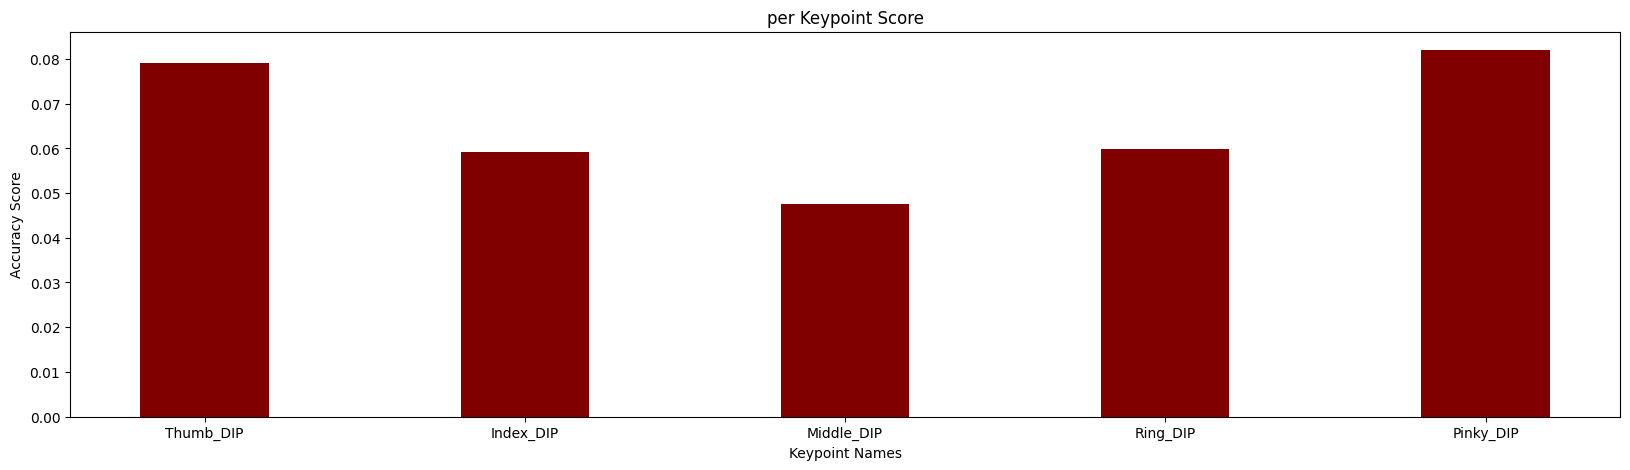

time: 226 ms (started: 2023-08-24 09:14:36 +00:00)


In [ ]:
accuracy_per_keypoint_mean = accuracy_per_keypoint / 1000
fig = plt.figure(figsize=(20,5))
plt.bar(KEYS_KEYPOINTS, accuracy_per_keypoint_mean, color= 'maroon', width=0.4)
plt.xlabel("Keypoint Names")
plt.ylabel("Accuracy Score")
plt.title("per Keypoint Score")
plt.show()

In [ ]:

# tunned lr
accuracy_per_keypoint / 1000

array([0.07215997, 0.05745906, 0.04593006, 0.05626675, 0.07761504])

time: 3.68 ms (started: 2023-08-24 13:44:19 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.07149949, 0.05810529, 0.04661782, 0.05682884, 0.0797921 ])

time: 5.6 ms (started: 2023-08-24 12:54:00 +00:00)


In [ ]:

# tunned lr
accuracy_per_keypoint / 1000

array([0.07164364, 0.05668097, 0.04581176, 0.05665978, 0.07738544])

time: 3.91 ms (started: 2023-08-24 09:38:52 +00:00)


#TIP

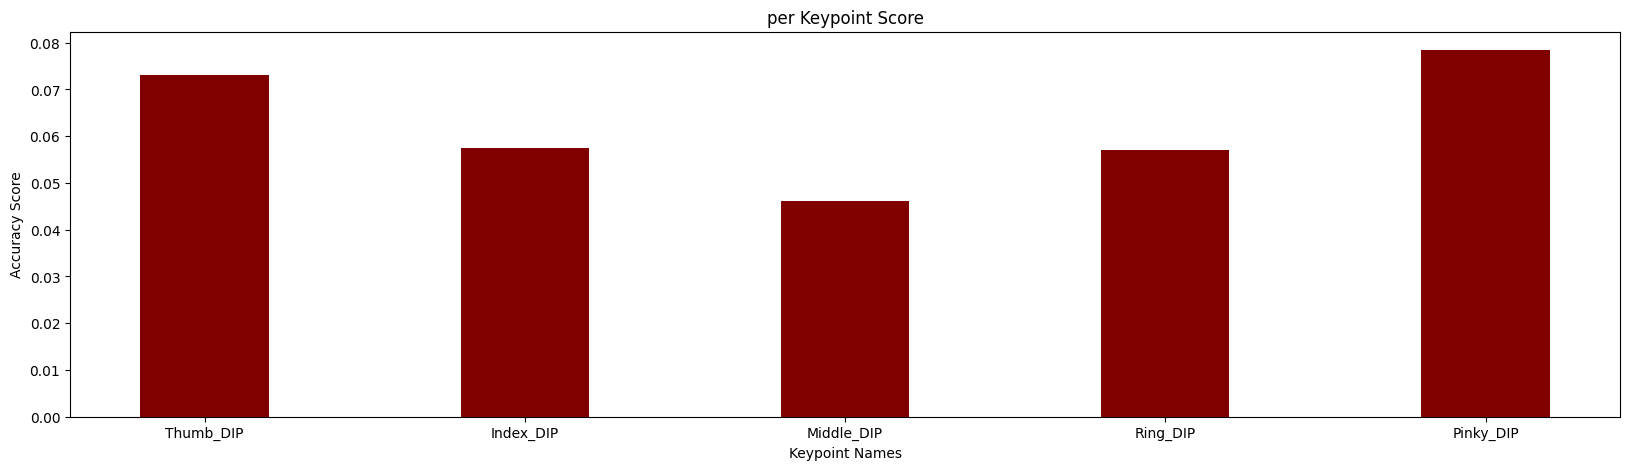

time: 224 ms (started: 2023-08-24 09:15:19 +00:00)


In [ ]:
accuracy_per_keypoint_mean = accuracy_per_keypoint / 1000
fig = plt.figure(figsize=(20,5))
plt.bar(KEYS_KEYPOINTS, accuracy_per_keypoint_mean, color= 'maroon', width=0.4)
plt.xlabel("Keypoint Names")
plt.ylabel("Accuracy Score")
plt.title("per Keypoint Score")
plt.show()

In [ ]:
accuracy_per_keypoint / 1000

array([0.09906349, 0.07695125, 0.06704245, 0.07525849, 0.09677097])

time: 9.32 ms (started: 2023-08-23 15:05:42 +00:00)


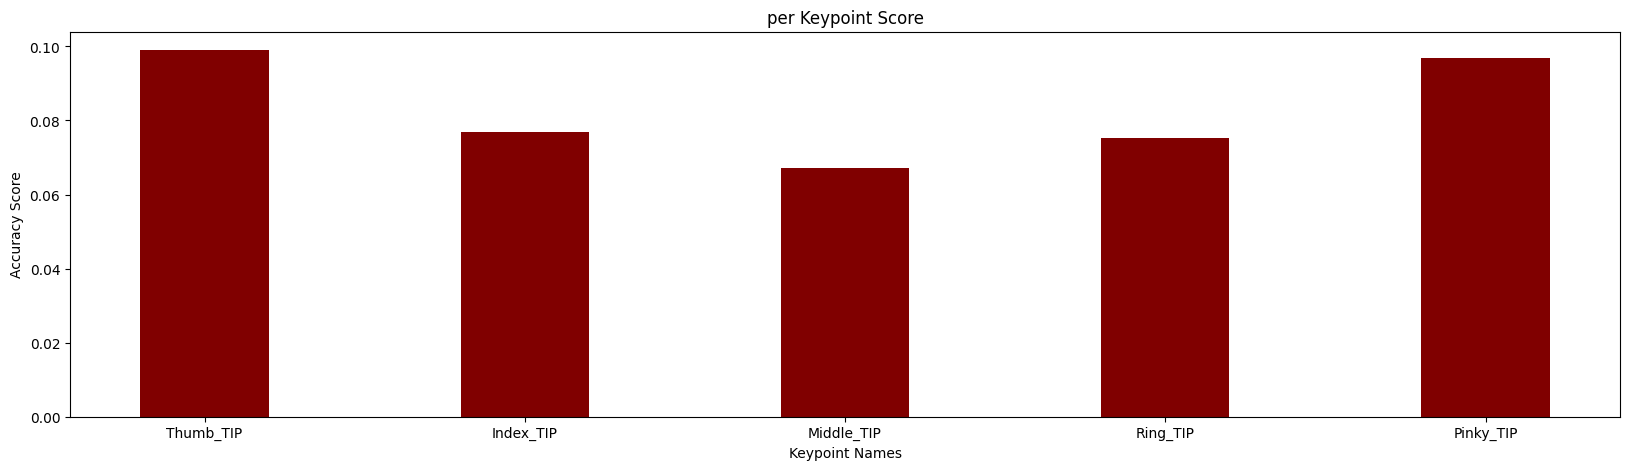

time: 254 ms (started: 2023-08-23 15:06:38 +00:00)


In [ ]:
accuracy_per_keypoint_mean = accuracy_per_keypoint / 1000
fig = plt.figure(figsize=(20,5))
plt.bar(KEYS_KEYPOINTS, accuracy_per_keypoint_mean, color= 'maroon', width=0.4)
plt.xlabel("Keypoint Names")
plt.ylabel("Accuracy Score")
plt.title("per Keypoint Score")
plt.show()

In [ ]:
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader)

In [ ]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:18<00:00, 55.06it/s]

time: 18.2 s (started: 2023-08-24 01:53:43 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.06653438, 0.05661125, 0.05221586, 0.05312582, 0.05967904])

time: 3.98 ms (started: 2023-08-23 03:11:32 +00:00)


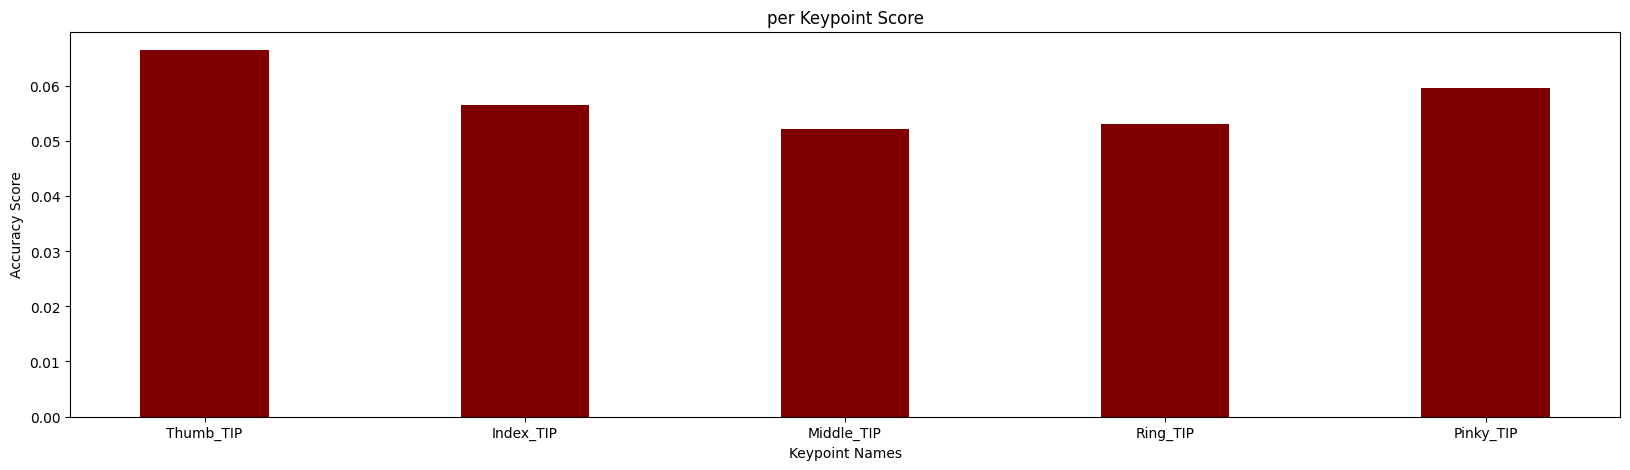

time: 230 ms (started: 2023-08-23 03:11:40 +00:00)


In [ ]:
accuracy_per_keypoint_mean = accuracy_per_keypoint / 1000
fig = plt.figure(figsize=(20,5))
plt.bar(KEYS_KEYPOINTS, accuracy_per_keypoint_mean, color= 'maroon', width=0.4)
plt.xlabel("Keypoint Names")
plt.ylabel("Accuracy Score")
plt.title("per Keypoint Score")
plt.show()

In [ ]:
accuracy_per_keypoint / 1000

array([0.09863969, 0.07612176, 0.06735832, 0.07607442, 0.09777972])

time: 6.25 ms (started: 2023-08-24 01:54:01 +00:00)


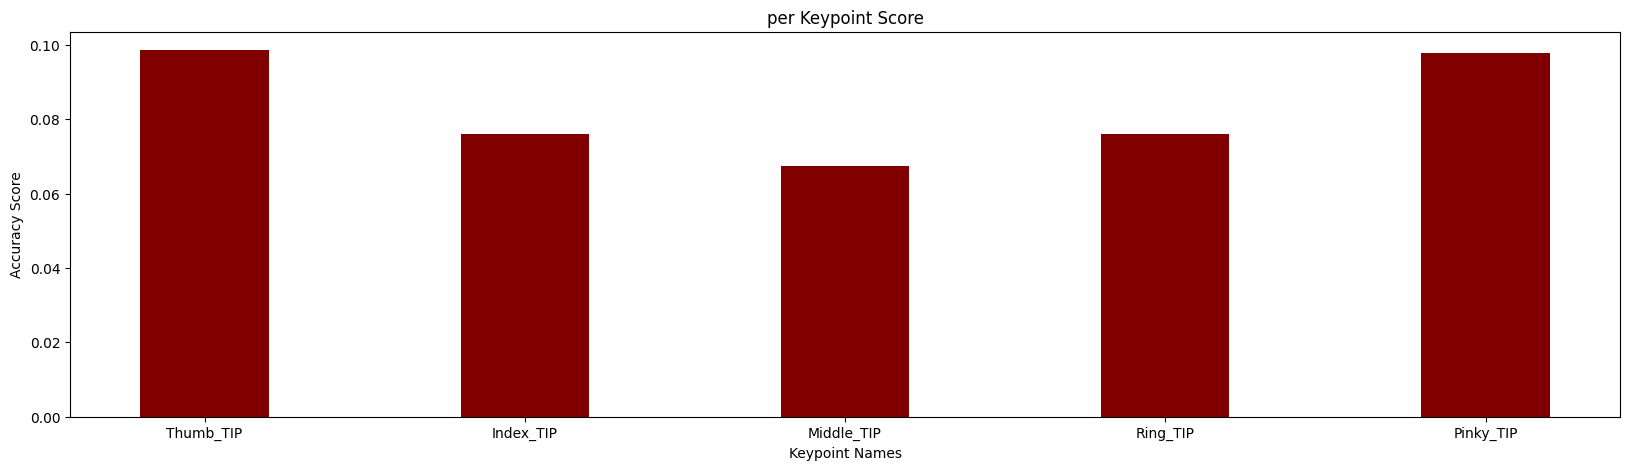

time: 222 ms (started: 2023-08-24 01:54:01 +00:00)


In [ ]:
accuracy_per_keypoint_mean = accuracy_per_keypoint / 1000
fig = plt.figure(figsize=(20,5))
plt.bar(KEYS_KEYPOINTS, accuracy_per_keypoint_mean, color= 'maroon', width=0.4)
plt.xlabel("Keypoint Names")
plt.ylabel("Accuracy Score")
plt.title("per Keypoint Score")
plt.show()

#PIP

In [ ]:
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader,FGK)

Epoch: 1/1000, Train Loss=0.7711237102, Val Loss=0.7162209086
Epoch: 2/1000, Train Loss=0.693930007, Val Loss=0.6883820014
Epoch: 3/1000, Train Loss=0.6582999013, Val Loss=0.6391760044
Epoch: 4/1000, Train Loss=0.6446601961, Val Loss=0.6449086866
Epoch: 5/1000, Train Loss=0.6256339947, Val Loss=0.6355855999
Epoch: 6/1000, Train Loss=0.6107390803, Val Loss=0.6075806181
Epoch: 7/1000, Train Loss=0.6093098725, Val Loss=0.6105707119
Epoch: 8/1000, Train Loss=0.5996973861, Val Loss=0.610232275
Epoch: 9/1000, Train Loss=0.5894951557, Val Loss=0.5928363047
Epoch: 10/1000, Train Loss=0.5929532, Val Loss=0.6014018884
Epoch: 11/1000, Train Loss=0.5850418263, Val Loss=0.5798715653
Epoch: 12/1000, Train Loss=0.5786598376, Val Loss=0.5858232284
Epoch: 13/1000, Train Loss=0.5852748235, Val Loss=0.60683812
Epoch: 14/1000, Train Loss=0.5794736724, Val Loss=0.5847089448
Epoch: 15/1000, Train Loss=0.5734863333, Val Loss=0.56972995
Epoch: 16/1000, Train Loss=0.582002987, Val Loss=0.5816666965
Epoch: 17/1

KeyboardInterrupt: ignored

time: 39min 27s (started: 2023-08-24 13:51:04 +00:00)


In [183]:
optimizer = optim.SGD(model.parameters(), lr=0.0005)

# membuat scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.4)
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader,FGK)

Epoch: 1/1000, Train Loss=0.4472248588, Val Loss=0.4719563127


KeyboardInterrupt: ignored

time: 2min 3s (started: 2023-08-24 15:46:22 +00:00)


In [184]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:17<00:00, 57.32it/s]

time: 17.5 s (started: 2023-08-24 15:48:29 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.07140889, 0.06020003, 0.04530881, 0.05667483, 0.08538977])

time: 3.31 ms (started: 2023-08-24 14:53:34 +00:00)


In [ ]:
accuracy_per_keypoint / 1000

array([0.06692485, 0.05676869, 0.04231762, 0.05240385, 0.0784732 ])

time: 3.52 ms (started: 2023-08-24 14:58:32 +00:00)


In [156]:
accuracy_per_keypoint / 1000

array([0.06565876, 0.05764851, 0.04373759, 0.05393796, 0.07990633])

time: 4.45 ms (started: 2023-08-24 15:08:36 +00:00)


In [159]:
accuracy_per_keypoint / 1000

array([0.06645251, 0.05927267, 0.04438709, 0.05313243, 0.076963  ])

time: 6.52 ms (started: 2023-08-24 15:11:55 +00:00)


In [162]:
accuracy_per_keypoint / 1000

array([0.06650599, 0.05810557, 0.04430458, 0.05353857, 0.07713674])

time: 13.5 ms (started: 2023-08-24 15:16:15 +00:00)


In [165]:
accuracy_per_keypoint / 1000

array([0.0647199 , 0.05679364, 0.04094215, 0.05045844, 0.07484849])

time: 13.2 ms (started: 2023-08-24 15:22:23 +00:00)


In [168]:

# savepoint
accuracy_per_keypoint / 1000

array([0.06289315, 0.05492383, 0.04023751, 0.04949156, 0.0716499 ])

time: 4.43 ms (started: 2023-08-24 15:26:19 +00:00)


In [172]:
accuracy_per_keypoint / 1000

array([0.06353029, 0.0546512 , 0.04029524, 0.05037591, 0.07255161])

time: 3.8 ms (started: 2023-08-24 15:33:06 +00:00)


In [175]:

#checkpoint
accuracy_per_keypoint / 1000

array([0.06267029, 0.05446323, 0.04004915, 0.04928404, 0.07096695])

time: 5.14 ms (started: 2023-08-24 15:36:28 +00:00)


In [179]:
accuracy_per_keypoint / 1000

array([0.06268717, 0.05459754, 0.0400846 , 0.04929389, 0.07133252])

time: 5.04 ms (started: 2023-08-24 15:40:41 +00:00)


In [182]:
accuracy_per_keypoint / 1000

array([0.06262136, 0.05427532, 0.04000085, 0.04917975, 0.07111458])

time: 9.85 ms (started: 2023-08-24 15:45:34 +00:00)


In [185]:
accuracy_per_keypoint / 1000

array([0.06271952, 0.05429353, 0.0400398 , 0.04926072, 0.07127592])

time: 7.27 ms (started: 2023-08-24 15:48:46 +00:00)


In [176]:
torch.save(model.state_dict(),"pip_2")

time: 21.8 ms (started: 2023-08-24 15:37:28 +00:00)


#MCP

In [202]:
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader,FGK)

Epoch: 1/1000, Train Loss=0.4208048884, Val Loss=0.4300514567
Epoch: 2/1000, Train Loss=0.4171412666, Val Loss=0.4249313776
Epoch: 3/1000, Train Loss=0.4154501659, Val Loss=0.4235730293
Epoch: 4/1000, Train Loss=0.4139840151, Val Loss=0.4226138957


KeyboardInterrupt: ignored

time: 9min 15s (started: 2023-08-24 16:44:25 +00:00)


In [232]:
optimizer = optim.SGD(model.parameters(), lr=0.01, nesterov = True, momentum=0.8)
# membuat scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.4)
# @title
# membuat trainer
trainer = Trainer(model, criterion, optimizer, train_config, scheduler)
# TRaining model
model = trainer.train(train_dataloader, val_dataloader, test_dataloader,FGK)

Epoch: 1/1000, Train Loss=0.3644034567, Val Loss=0.3806242547


KeyboardInterrupt: ignored

time: 2min 9s (started: 2023-08-24 18:01:00 +00:00)


In [233]:
# melakukan testing
accuracy_all_image = []
accuracy_per_keypoint = [0] * N_KEYPOINTS

for data in tqdm(test_dataloader):
    inputs = data["image"]
    inputs = inputs.cuda()
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.cpu()
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    batched_accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    for accuracy_keypoint in batched_accuracy_keypoint:
      accuracy_per_keypoint = accuracy_per_keypoint +  accuracy_keypoint

    accuracy_image = batched_accuracy_keypoint.mean(axis=1)
    accuracy_all_image.extend(list(accuracy_image))

100%|██████████| 1000/1000 [00:15<00:00, 65.30it/s]

time: 15.3 s (started: 2023-08-24 18:03:19 +00:00)


In [193]:
accuracy_per_keypoint / 1000

array([0.04568004, 0.0598823 , 0.05407314, 0.04540911, 0.06401457,
       0.08907964])

time: 8.78 ms (started: 2023-08-24 16:23:00 +00:00)


In [196]:
accuracy_per_keypoint / 1000

array([0.04506535, 0.05542493, 0.05242254, 0.04239675, 0.05268514,
       0.07244856])

time: 5.28 ms (started: 2023-08-24 16:34:46 +00:00)


In [200]:
accuracy_per_keypoint / 1000

array([0.04186717, 0.05267775, 0.04963625, 0.03956072, 0.05027707,
       0.07165573])

time: 13 ms (started: 2023-08-24 16:43:34 +00:00)


In [216]:
accuracy_per_keypoint / 1000

array([0.0403948 , 0.04885782, 0.04577711, 0.03726462, 0.0476799 ,
       0.06751434])

time: 4.43 ms (started: 2023-08-24 17:48:22 +00:00)


In [221]:
accuracy_per_keypoint / 1000

array([0.03903153, 0.04830824, 0.0453116 , 0.03627198, 0.04595496,
       0.06443538])

time: 3.51 ms (started: 2023-08-24 17:52:54 +00:00)


In [234]:
accuracy_per_keypoint / 1000

array([0.03934461, 0.04813566, 0.04530917, 0.03620333, 0.04597589,
       0.06436079])

time: 3.61 ms (started: 2023-08-24 18:03:34 +00:00)


In [235]:
torch.save(model.state_dict(),"mcp_4")

time: 31.9 ms (started: 2023-08-24 18:03:58 +00:00)


In [ ]:
class PostProcessOutput(nn.Module):
  def __init__(self, n_keypoint, heatmap_size):
      super().__init__()
      self.keypoint = n_keypoint
      self.size = heatmap_size

  def heatmaps_to_coordinates(self, heatmaps):

      # mendapatkan banyak image dalam batch
      # heatmaps = heatmaps.cpu()
      # heatmaps = heatmaps.detach().numpy()

      batch_size = heatmaps.shape[0]

      # mendapatkan nilai total dari heatmap width dan height
      sums = heatmaps.sum(dim=[2, 3], keepdim=True)

      # normalisasi heatmap dengan membagi nilai heatmap dengan nilai total heatmap
      # sehingga hasil berada pada range 0 dan 1
      normalized = heatmaps / sums

      # mendapatkan nilai total pada normalized heatmap dari width dan height nya
      x_prob = normalized.sum(axis=2)
      y_prob = normalized.sum(axis=3)

      # membuat heatmap baru sebagai kordinat dengan size 0 hingga 127 -> dimensi
      arr = torch.arange(0, self.size, dtype=torch.float32).unsqueeze(0).unsqueeze(1).cuda()
      arr = arr.expand(batch_size, self.keypoint, self.size)


      # mendapatkan kordinat dengan mengkalikan normalized vector heatmap dengan heatmap kordinat baru
      # ini bertujuan untuk meningkatkan keakuratan dari keypoint output menggunakan value yang telah di normalisasi
      x = (arr * x_prob).sum(axis=2)
      y = (arr * y_prob).sum(axis=2)

      # register kordinat pada array
      keypoints = torch.stack([x, y], dim=-1)
      keypoints = keypoints / self.size

      return keypoints

  def forward(self, x):
      return self.heatmaps_to_coordinates(x)


class KeypointPredictor(nn.Module):
  def __init__(self, in_channel, out_channel, UnetModel):
      super().__init__()
      self.post_processing = PostProcessOutput(out_channel, 128)
      self.unet = UnetModel

  def forward(self, x):
      heatmaps = self.unet.forward(x)
      post_processed = self.post_processing(heatmaps)
      return post_processed

time: 4.43 ms (started: 2023-08-24 02:11:16 +00:00)


In [ ]:
predictor = KeypointPredictor(3, N_KEYPOINTS, model)
# predictor.eval()
# torch.quantization.convert(model, inplace=True)

time: 489 µs (started: 2023-08-24 02:11:20 +00:00)


In [ ]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 49.8 MB/s eta 0:00:00
time: 7.26 s (started: 2023-08-24 02:11:24 +00:00)


In [ ]:
import onnx

time: 30.9 ms (started: 2023-08-24 02:11:31 +00:00)


In [ ]:

dummy_input = torch.randn(1, 3, 128, 128)
dummy_input = dummy_input.to(test_config["device"])
torch.onnx.export(
         predictor,
         dummy_input,
         "regresi1.onnx",
         export_params=True,
         opset_version=11,
         do_constant_folding=True,
         input_names = ['input'],
         output_names = ['output'])

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

time: 617 ms (started: 2023-08-24 02:11:31 +00:00)
